## TP4  Segmentation d'images

Arij Habbechi
Yasmine Gharbi
RT4/1

#### Importer les librairies et bibliothéques nécessaires

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.filters import threshold_otsu,threshold_multiotsu
from skimage.transform import resize
import cv2
import pandas as pd
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw

## I.1 **Segmentation par seuillage**

###Question:
1. Lire l’image de test 06.png,  puis afficher-là.
2. Afficher son histogramme. Distinguer les zones séparables sur histogramme.
3. Calculer manuellement un seuil de segmentation et segmenter l'image. Afficher le résultat de segmentation.
4. Calculer le seuil avec la méthode d’Otsu et affichez le résultat de la segmentation. Comparer avec le seuillage manuel.

Lire l’image de test 06.png,  puis afficher-là.

Text(0.5, 1.0, 'Image en niveaux de gris')

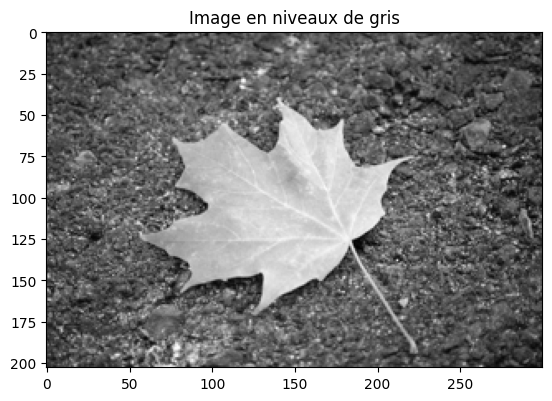

In [ ]:
# Charger l'image
image = cv2.imread("06.png")

# Convertir en niveaux de gris
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Afficher l'image
plt.imshow(image_gray, cmap="gray")
plt.title('Image en niveaux de gris')

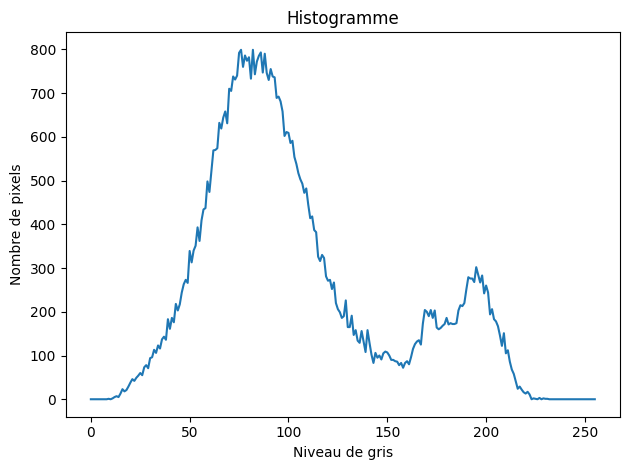

In [ ]:
# Calculer l'histogramme
hist = cv2.calcHist([image_gray], [0], None, [256], [0, 256])
# Afficher l'histogramme
plt.plot(hist)
plt.title('Histogramme')
plt.xlabel('Niveau de gris')
plt.ylabel('Nombre de pixels')

plt.tight_layout()
plt.show()

In [ ]:
# Déterminer manuellement un seuil de segmentation
seuil = 150
# Segmenter l'image en utilisant le seuil
def segmentation_seuil(image_gray, seuil):
    _, segmented_image = cv2.threshold(image_gray, seuil, 255, cv2.THRESH_BINARY)
    return segmented_image

segmented_image=segmentation_seuil(image_gray, seuil)

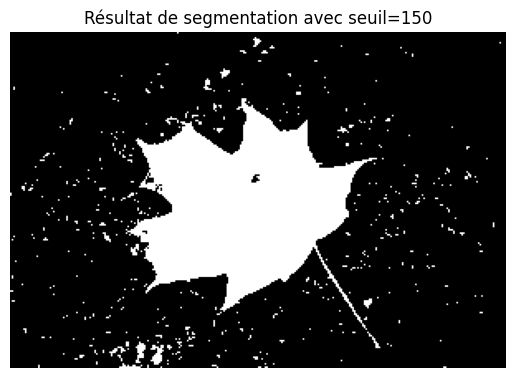

In [ ]:
# Afficher le résultat de segmentation
plt.imshow(segmented_image, cmap='gray')
plt.title('Résultat de segmentation avec seuil={}'.format(seuil))
plt.axis('off')
plt.show()

## Segmentation global automatique :

In [ ]:
def global_thresholding_auto(image, epsilon=1):
    # Calcul de l'histogramme de l'image
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Sélection du seuil initial T0
    T = 128  # Valeur arbitraire initiale
    delta_T = epsilon + 1  # Initialisation de la variation du seuil

    # Boucle jusqu'à ce que les variations de T soient inférieures à epsilon
    while delta_T > epsilon:
        # Séparation de l'image en deux groupes en fonction du seuil actuel T
        group1 = image[image <= T]
        group2 = image[image > T]

        # Calcul des intensités moyennes m1 et m2 des groupes G1 et G2
        m1 = np.mean(group1)
        m2 = np.mean(group2)

        # Calcul du nouveau seuil T
        new_T = (m1 + m2) / 2

        # Calcul de la variation du seuil
        delta_T = abs(new_T - T)

        # Mise à jour du seuil
        T = new_T

    # Binarisation de l'image finale en utilisant le seuil calculé
    _, segmented_image = cv2.threshold(image, T, 255, cv2.THRESH_BINARY)

    return segmented_image, T


Seuil calculé: 128.76856329783973


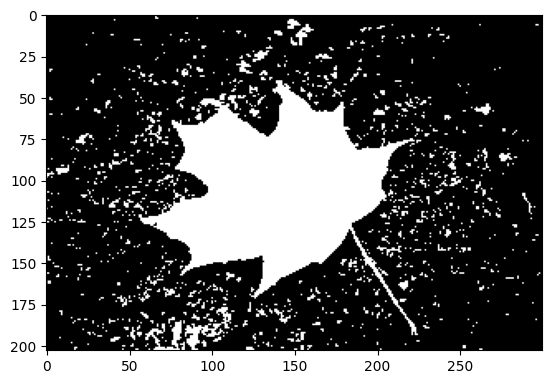

In [ ]:
# Appliquer le seuillage global automatique
segmented_image, threshold_value = global_thresholding_auto(image)

# Afficher le résultat de la segmentation
plt.imshow( segmented_image, cmap='gray')
print("Seuil calculé:", threshold_value)

### Méthode d'Otsu

In [ ]:
import numpy as np
import cv2

def otsu_thresholding(image):
    # Compute histogram of image pixels
    pixel_counts, bin_edges = np.histogram(image, bins=256, range=(0, 256))
    total_pixels = image.size

    # Compute total mean of the image
    mean_total = np.dot(bin_edges[:-1], pixel_counts) / total_pixels

    # Initialize variables to find the optimal threshold
    max_between_class_variance = 0
    optimal_threshold = 0
    weight_background = 0
    sum_background = 0

    for i in range(1, 256):
        weight_background += pixel_counts[i-1]
        sum_background += (i-1) * pixel_counts[i-1]

        if weight_background == 0 or weight_background == total_pixels:
            continue

        weight_foreground = total_pixels - weight_background
        mean_background = sum_background / weight_background
        mean_foreground = (mean_total - sum_background) / weight_foreground

        # Calculate between-class variance
        between_class_variance = (weight_background * weight_foreground *
                                  (mean_background - mean_foreground) ** 2)

        # Check if new maximum found
        if between_class_variance > max_between_class_variance:
            max_between_class_variance = between_class_variance
            optimal_threshold = i

            # Apply threshold to image
    _, segmented_image = cv2.threshold(image, optimal_threshold, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return segmented_image, optimal_threshold


Optimal threshold is: 231


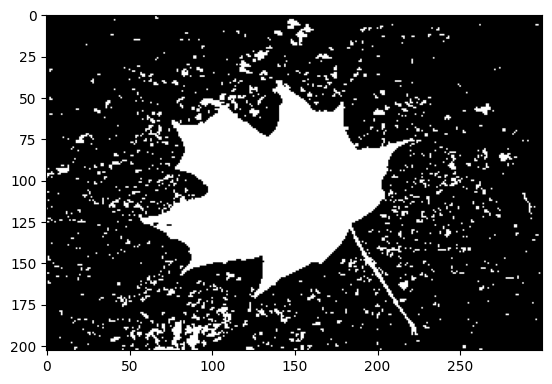

In [ ]:
image_otsu, threshold= otsu_thresholding(image_gray)
plt.imshow(image_otsu, cmap='gray')
print("Optimal threshold is:", threshold)

1. Seuillage Manuel
* Seuil choisi : 150
Résultat : La feuille est bien segmentée, mais il y a encore des points de bruit significatifs autour de la feuille. Le choix manuel du seuil permet de contrôler la segmentation, mais il peut être suboptimal, particulièrement dans des images avec beaucoup de bruit ou des variations d'intensité.
2. Seuillage Global Automatique
* Seuil calculé : 128.77, qui est proche du seuil choisi, l'image est  similaire au seuillage manuel, mais le bruit reste présent.

 **Le seuillage global automatique ajuste dynamiquement le seuil en fonction de l'histogramme de l'image. Cependant, il peut encore être affecté par le bruit et les variations d'intensité dans l'image.**

3. Méthode d'Otsu
* Seuil calculé : 231
* Résultat : La feuille est correctement segmentée avec moins de bruit apparent par rapport aux deux autres méthodes.

En effet, La méthode d'Otsu minimise la variance intra-classe et est efficace pour trouver un seuil optimal en présence de bruit, mais peut ne pas toujours gérer des distributions de niveaux de gris complexes.

➡  **Effet du Bruit et Seuillage Global**


Le bruit dans les images peut fausser les résultats de segmentation en introduisant des pixels qui ne correspondent pas à la région d'intérêt. Les méthodes de seuillage globales, comme le seuillage manuel et automatique, ne prennent pas en compte l'information de voisinage et peuvent donc être fortement influencées par le bruit. En revanche, la méthode d'Otsu, en cherchant à minimiser la variance intra-classe, peut offrir une meilleure résistance au bruit, mais elle n'est pas infaillible.

## I.2 **Segmentation par kmeans**
— Cette méthode vise à diviser l'image en k classes (régions) statistiquement homogènes, dont les valeurs
de niveaux de gris sont similaires au (proches du) centre (moyenne) de la classe.

— Cette similarité est estimée par calcul de distance entre la valeur du niveau de gris et du centre.

— Il faut connaitre à priori le nombre de classes (régions)

##Question:
 Lire l’image de test 11.png et appliquer l’algorithme des k-means pour segmenter l'image

In [ ]:
def k_means(image, k, max_iterations=100):
    # Initialisation aléatoire des centres des clusters
    rows, cols = image.shape
    centers = np.random.randint(0, 256, k)
    centers = np.sort(centers)

    # Initialisation de l'affectation des pixels aux clusters
    cluster_assignments = np.zeros((rows, cols))

    # Nombre maximum d'itérations
    for _ in range(max_iterations):
        # Calcul des distances des pixels par rapport aux centres des clusters
        distances = np.abs(np.expand_dims(image, axis=-1) - centers)

        # Affectation de chaque pixel au cluster le plus proche
        new_cluster_assignments = np.argmin(distances, axis=-1)

        # Vérification s'il y a eu un changement dans l'affectation des pixels
        if np.array_equal(cluster_assignments, new_cluster_assignments):
            break  # Arrêt si aucune modification n'a eu lieu

        # Mise à jour de l'affectation des pixels
        cluster_assignments = new_cluster_assignments

        # Recalcul des centres des clusters
        for i in range(k):
            cluster_points = image[cluster_assignments == i]
            if len(cluster_points) > 0:
                centers[i] = np.mean(cluster_points)

    # Remplacer chaque pixel par la valeur du centre de son cluster
    clustered_image = np.zeros_like(image)
    for i in range(k):
        clustered_image[cluster_assignments == i] = int(centers[i])

    return clustered_image


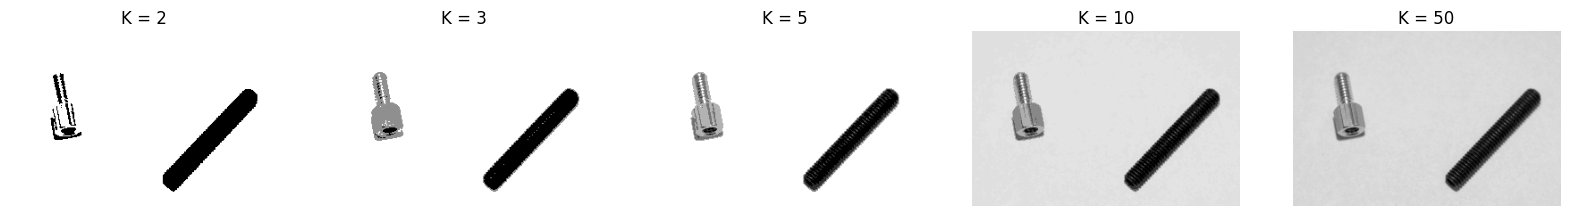

In [ ]:
# Charger l'image en niveaux de gris
image = cv2.imread("11.png", cv2.IMREAD_GRAYSCALE)

# Définir les valeurs de K à tester
K_values = [2,3, 5,10, 50]

# Créer un dictionnaire pour stocker les images segmentées pour chaque valeur de K
segmented_images = {}

# Appliquer l'algorithme des K-moyennes pour chaque valeur de K
for k in K_values:
    clustered_image = k_means(image, k)
    # Stocker l'image segmentée dans le dictionnaire
    segmented_images[k] = clustered_image

# Afficher les images segmentées
fig, axes = plt.subplots(1, len(K_values), figsize=(20, 5))
for i, k in enumerate(K_values):
    axes[i].imshow(segmented_images[k], cmap='gray')
    axes[i].set_title("K = {}".format(k))
    axes[i].axis('off')

plt.show()

L'image ci-dessus montre les résultats de la segmentation par l'algorithme des K-means avec différentes valeurs de K.

* **K=2** : L'image est segmentée en deux classes, ce qui distingue de manière basique les objets de l'arrière-plan, mais manque de détails dans les objets eux-mêmes.
* **K=3**  : Avec trois classes, une troisième région apparaît, permettant de différencier certains détails des objets, mais certaines parties sont encore indistinctes.
* **K=5** : Cinq classes permettent une meilleure segmentation, distinguant clairement les objets et certains détails internes.

* **K=50** : À ce niveau, la segmentation devient très fine, et les variations internes des objets sont bien capturées, mais cela peut entraîner une sur-segmentation où des régions homogènes sont divisées en plusieurs segments ce qui rend l'analyse plus complexe.



## I.3 **Segmentation par la méthode de croissance de région**

Pour segmenter une région R ayant un écart type de sigma_R.

— on commence par un point germe (seed) d’un niveau de gris donné (c’est la valeur initiale de la moyenne de R)

— puis on croit la région autour du germe, en ajoutant à la région tous les points avoisinants dont les niveaux de gris I(x; y) vérifient la condition:

|I(x; y) - mu_R|<= sigma_R, où mu_R est la moyenne de R.

— Recalculer la moyenne de R après croissance
— Réitérer les opérations 2 et 3, jusqu’à ce qu’il n’y ait plus de croissance.

Question:
1. Lire l’image mandrillgray.bmp et afficher la.
2. Choisir manuellement le point germe. Appliquer l'algorithme de croissance de région, pour segmenter une région d’écart type 0.1, autour de ce germe-là.
3. Afficher l’image segmentée sur l’image initiale

4. Essayez à présent de segmenter une région dont vous sélectionnerez le germe au moyen de la souris. Variez l’écart type. Commenter.
5. Modifier le code précédent pour segmenter 4 régions.

(-0.5, 511.5, 511.5, -0.5)

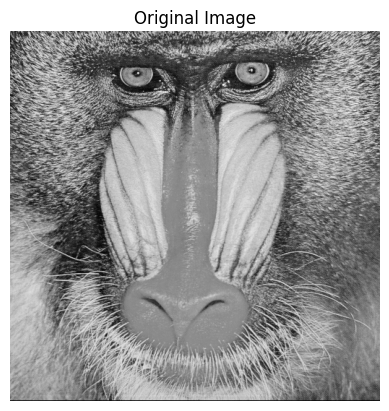

In [ ]:
# Charger l'image
image = cv2.imread("mandrillgray.bmp", cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

In [ ]:
def segmenter_region(image, seed, sigma_R):
    # Initialisation de la région avec le point germe
    region = set([seed])
    rows, cols = image.shape
    segmented_image = np.zeros_like(image)

    # Partie 2 de l'algorithme : Croissance de la région
    while True:
        # Calcul de la moyenne de la région
        mu_R = np.mean([image[pixel] for pixel in region])

        # Liste pour stocker les nouveaux pixels à ajouter à la région
        nouveaux_pixels = []

        # Parcours des pixels adjacents à la région
        for pixel in region:
            x, y = pixel
            voisins = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]

            # Ajout des pixels voisins vérifiant la condition à la région
            for voisin in voisins:
                if (0 <= voisin[0] < rows and 0 <= voisin[1] < cols and
                    voisin not in region and abs(image[voisin] - mu_R) <= sigma_R):
                    nouveaux_pixels.append(voisin)

        # Si aucun nouveau pixel à ajouter, arrêter la croissance
        if len(nouveaux_pixels) == 0:
            break

        # Ajout des nouveaux pixels à la région
        region.update(nouveaux_pixels)

    # Marquer la région dans l'image segmentée
    for pixel in region:
        segmented_image[pixel] = 255

    # Retourner l'image segmentée
    return segmented_image, region



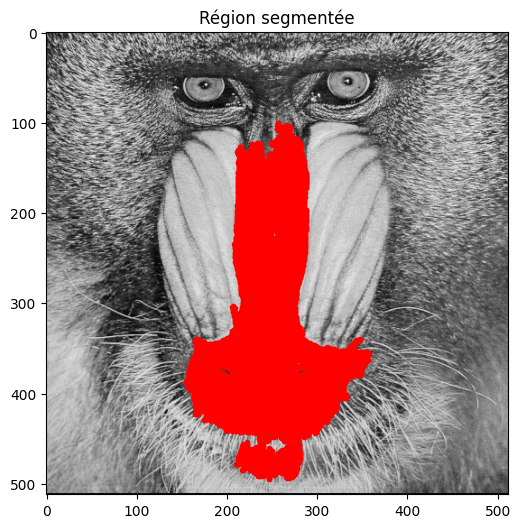

In [ ]:
seed = (250, 250)  # Point germe au centre de l'image
sigma_R = 20  # Écart type de la région

image_segmentée, region_segmentee = segmenter_region(image, seed, sigma_R)


# Plot de l'image
plt.figure(figsize=(8, 6))
plt.imshow(image, cmap='gray')

# Plot de la région segmentée
region_x, region_y = zip(*region_segmentee)
plt.scatter(region_y, region_x, color='red', marker='.')
plt.title('Région segmentée')
plt.show()

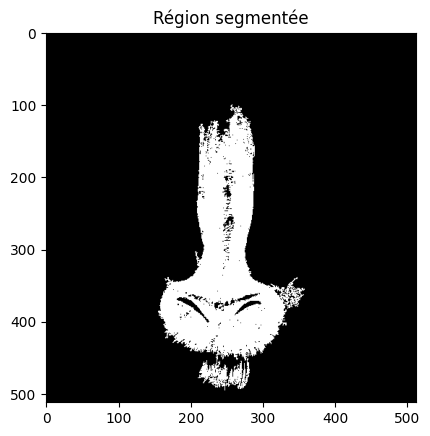

In [ ]:
plt.imshow(image_segmentée, cmap='gray')
plt.title('Région segmentée')
plt.show()

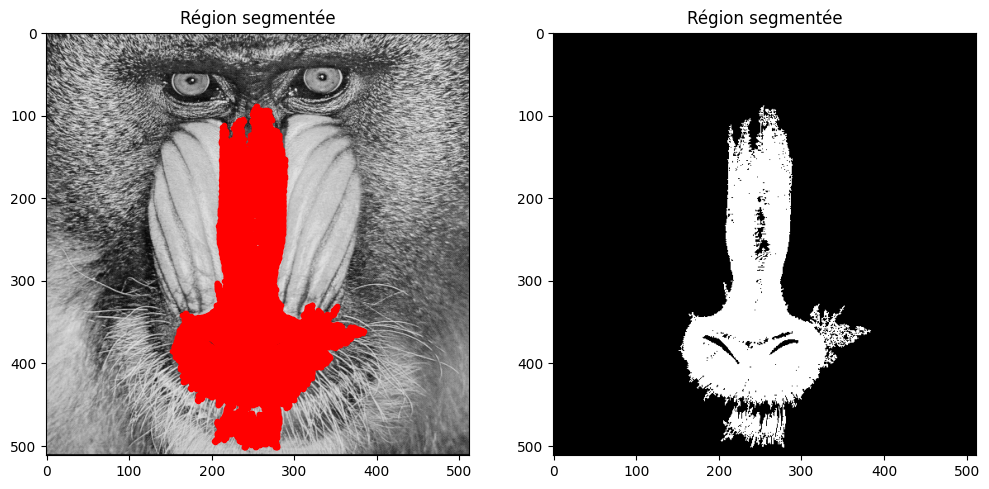

In [ ]:
def select_seed(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        param.append((y, x))

# Charger l'image
image = cv2.imread("mandrillgray.bmp", cv2.IMREAD_GRAYSCALE)
seed = []

# Créer une fenêtre pour sélectionner le point germe
cv2.imshow("Select Seed", image)
cv2.setMouseCallback("Select Seed", select_seed, seed)

# Attendre la sélection du point germe
cv2.waitKey(0)
cv2.destroyAllWindows()

# Si un point germe a été sélectionné
if seed:
    # Convertir le point germe en format attendu (ligne, colonne)
    seed_point = (seed[0][1], seed[0][0])

    # Segmenter la région
    _, region_segmentee = segmenter_region(image, seed_point, 0.1 * 255)

    # Plot de la région segmentée
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot de la région segmentée sur le premier subplot
    axes[0].imshow(image, cmap='gray')
    region_x, region_y = zip(*region_segmentee)
    axes[0].scatter(region_y, region_x, color='red', marker='.')
    axes[0].set_title('Région segmentée')

    # Plot de la région segmentée sur le deuxième subplot
    segmented = np.zeros_like(image)
    for pixel in region_segmentee:
        segmented[pixel] = 255
    axes[1].imshow(segmented, cmap='gray')
    axes[1].set_title('Région segmentée')

    plt.show()

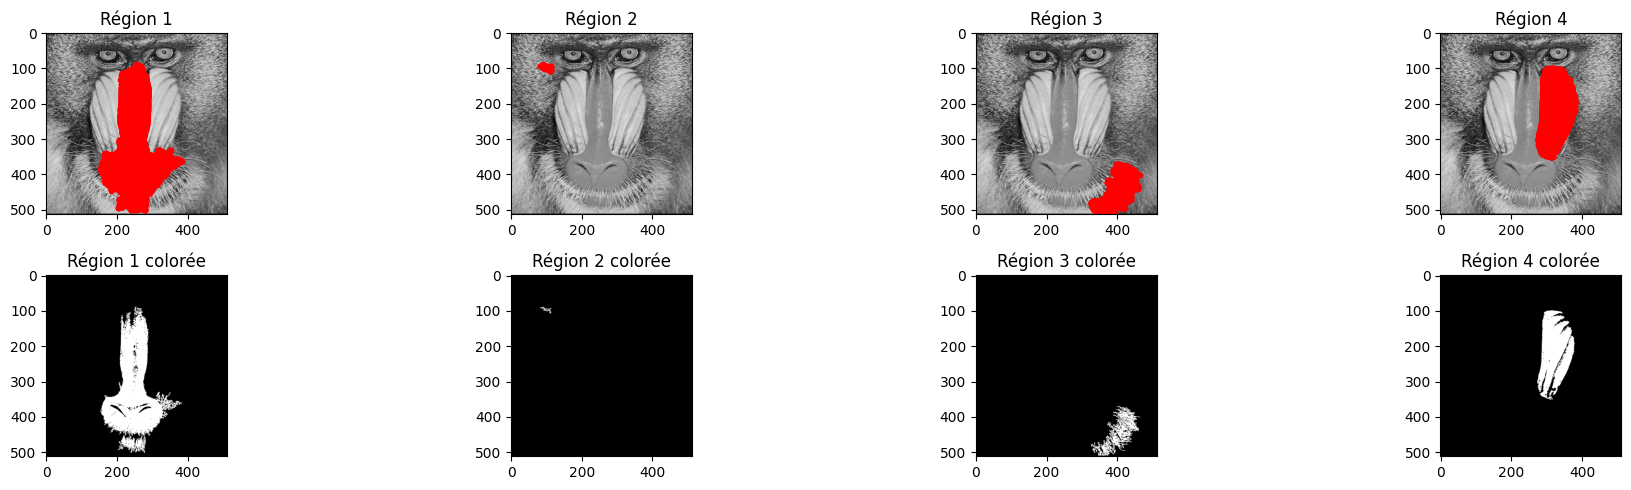

In [ ]:
def segmenter_regions(image, seeds, sigma_R):
    # Initialisation des régions avec les points germes
    regions = [set([seed]) for seed in seeds]

    # Partie 2 de l'algorithme : Croissance des régions
    while True:
        # Liste pour stocker les nouveaux pixels à ajouter à chaque région
        nouveaux_pixels = [[] for _ in range(len(regions))]

        # Parcours des régions
        for idx, region in enumerate(regions):
            # Calcul de la moyenne de la région
            mu_R = np.mean([image[pixel] for pixel in region])

            # Parcours des pixels adjacents à la région
            for pixel in region:
                x, y = pixel
                voisins = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]

                # Ajout des pixels voisins vérifiant la condition à la région
                for voisin in voisins:
                    if voisin not in region:
                        pixel_value = image[voisin]
                        if abs(pixel_value - mu_R) <= sigma_R:
                            # Vérifier que le pixel n'appartient pas déjà à une autre région
                            pixel_in_other_region = False
                            for other_region_idx, other_region in enumerate(regions):
                                if voisin in other_region and other_region_idx != idx:
                                    pixel_in_other_region = True
                                    break
                            if not pixel_in_other_region:
                                nouveaux_pixels[idx].append(voisin)

        # Si aucun nouveau pixel à ajouter dans aucune région, arrêter la croissance
        if all(len(nouveaux_pixels[i]) == 0 for i in range(len(regions))):
            break

        # Ajout des nouveaux pixels à chaque région
        for idx, region_pixels in enumerate(nouveaux_pixels):
            regions[idx].update(region_pixels)

    # Retourner les régions segmentées
    return regions

# Entrée manuelle des points germes
seeds = [(250,250), (100, 100), (400, 400), (200, 300)]


# Charger l'image
image = plt.imread("mandrillgray.bmp")

# Segmenter les régions
regions_segmentees = segmenter_regions(image, seeds, 0.1 * 255)

# Afficher les plots des régions segmentées
fig, axes = plt.subplots(2, 4, figsize=(20, 5))

for i, region in enumerate(regions_segmentees):
    # Plot de la région segmentée
    axes[0, i].imshow(image, cmap='gray')
    region_x, region_y = zip(*region)
    axes[0, i].scatter(region_y, region_x, color='red', marker='.')
    axes[0, i].set_title(f"Région {i+1}")

    # Plot de la région colorée en rouge
    masked_image = np.zeros_like(image)
    for point in region:
        masked_image[point] = 255
    axes[1, i].imshow(masked_image, cmap='gray')
    axes[1, i].set_title(f"Région {i+1} colorée")

plt.tight_layout()
plt.show()

1. Segmentation d'une seule région
L'image montre la segmentation d'une seule région autour du point germe initial sur le visage du mandrill.

  * Point germe : Centré sur le nez du mandrill.
  * Écart type (σ_R) : 20,  couvre principalement le nez et une partie de la bouche du mandrill.
2. Segmentation de plusieurs régions
Les autres images montrent la segmentation de quatre régions distinctes sur le visage du mandrill, chacune autour de différents points germes.

  * Observations:
    * Région 1 : Segmente efficacement le nez et une partie de la bouche, illustrant une bonne capture des caractéristiques homogènes autour du point germe.
    * Région 2 : Segmente une petite région autour de l'œil droit. La petite taille de la région est due à des variations d'intensité plus importantes autour de l'œil.
    * Région 3 : Segmente une partie de la joue gauche. La région est bien définie, mais limitée en taille.
    * Région 4 : similaire à la région 3.


➡ **Conclusion**

  La méthode de croissance de région permet de segmenter des zones homogènes autour de points germes. La performance dépend fortement de la sélection des points germes et des critères d'homogénéité. Les régions segmentées peuvent varier en taille et en précision selon les variations locales de l'intensité et la valeur de l'écart type choisi.

## II- **Application des méthodes de segmentation sur les images du dossier Dataset**

II-1 Chargement et visualisation des images

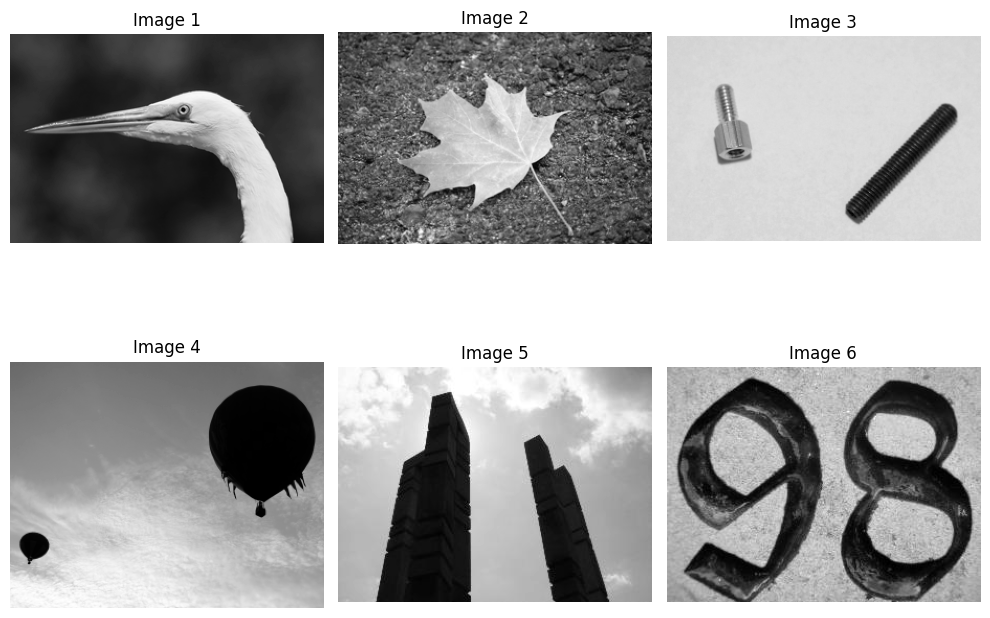

In [ ]:
# Charger les images
images_paths = ["03.png","06.png", "11.png", "13.png","17.png","18.png"]
images_gray = []

for path in images_paths:
    image = cv2.imread(path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    images_gray.append(image_gray)

# Afficher les images
num_images = len(images_gray)
cols = 3
rows = (num_images // cols) + (num_images % cols)  # Calcul du nombre de lignes

plt.figure(figsize=(10, 8))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images_gray[i], cmap="gray")
    plt.title("Image " + str(i+1))
    plt.axis("off")

plt.tight_layout()
plt.show()

## II-2 Choix des méthodes de segmentation

In [ ]:
def apply_all_segmentations(image, seuil=128, epsilon=1, k=3, max_iterations=100, seed=(0, 0), sigma_R=15):
    segmented_results = {}
    thresholds = {}

    # Segmentation par seuil simple
    segmented_results['threshold'] = segmentation_seuil(image, seuil)
    thresholds['manual threshold'] = seuil  # Valeur manuelle

    # Segmentation par seuillage global automatique
    segmented_results['global_auto'], auto_threshold = global_thresholding_auto(image, epsilon)
    thresholds['global_auto'] = auto_threshold  # Valeur automatique

    # Segmentation par la méthode d'Otsu
    segmented_results['otsu'], otsu_threshold = otsu_thresholding(image)
    thresholds['otsu'] = otsu_threshold

    # Segmentation par K-means
    segmented_results['k_means'] = k_means(image, k, max_iterations)

    # Segmentation par croissance de région
    segmented_results['region'], region_data = segmenter_region(image, seed, sigma_R)

    return segmented_results, thresholds


# II-3.Choix des métriques d'évaluation

Les métriques de performances se basent toutes sur les 4 notions suivantes : TP , FP , FN , TN.

**Dice**: Le coefficient de Dice est une mesure de similarité entre deux ensembles. Il est souvent utilisé pour évaluer la qualité de la segmentation en comparant une région segmentée avec une vérité terrain (ground truth).

**Jaccard**:  L'indice de Jaccard, également connu sous le nom de coefficient de similarité de Jaccard, est une autre mesure de similarité entre deux ensembles. Il compare la similarité et la diversité des ensembles segmentés et de vérité terrain.

In [ ]:
def calculate_metrics(ground_truth, *segmented_images):
    metrics = {}

    def dice_coefficient(truth, segmentation):
        intersection = np.logical_and(truth, segmentation).sum()
        return 2. * intersection / (np.sum(truth) + np.sum(segmentation))

    def jaccard_index(truth, segmentation):
        intersection = np.logical_and(truth, segmentation).sum()
        union = np.logical_or(truth, segmentation).sum()
        return intersection / union

    method_names = ['threshold', 'auto_threshold', 'otsu', 'kmeans', 'region_growing']

    for method, segmentation in zip(method_names, segmented_images):
        dice = dice_coefficient(ground_truth, segmentation)
        jaccard = jaccard_index(ground_truth, segmentation)
        metrics[method] = {'Jaccard': jaccard}

    return metrics

## Application des méthodes et des métriques :

In [ ]:
segmented_images_paths = ["03v.png", "06v.png", "11v.png", "13v.png", "17v.png", "18v.png"]
segmented_images_gray = []

for path in segmented_images_paths:
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    segmented_images_gray.append(image)

### Image1:

Text(0.5, 1.0, 'Image en niveaux de gris')

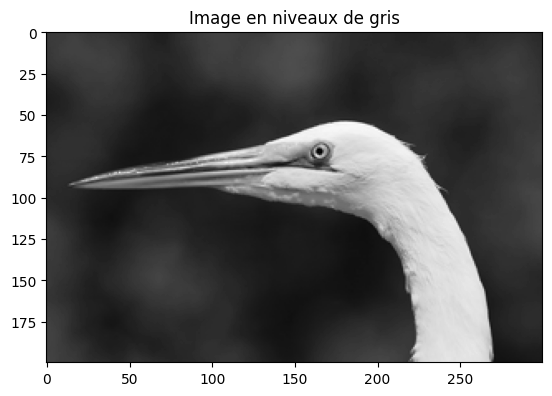

In [ ]:
# Afficher l'image
plt.imshow(images_gray[0], cmap="gray")
plt.title('Image en niveaux de gris')

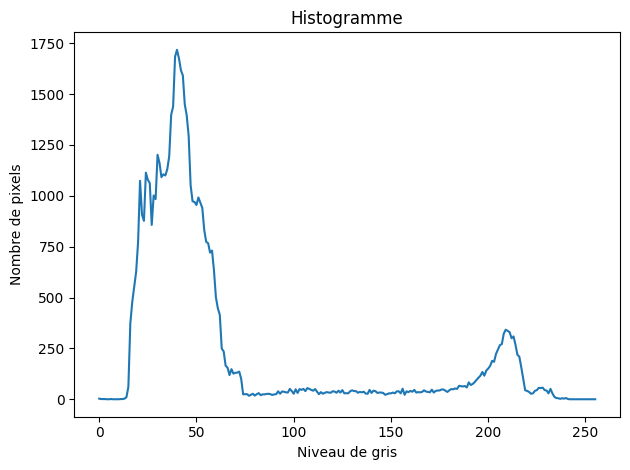

In [ ]:
# Calculer l'histogramme
hist = cv2.calcHist([images_gray[0]], [0], None, [256], [0, 256])
# Afficher l'histogramme
plt.plot(hist)
plt.title('Histogramme')
plt.xlabel('Niveau de gris')
plt.ylabel('Nombre de pixels')

plt.tight_layout()
plt.show()

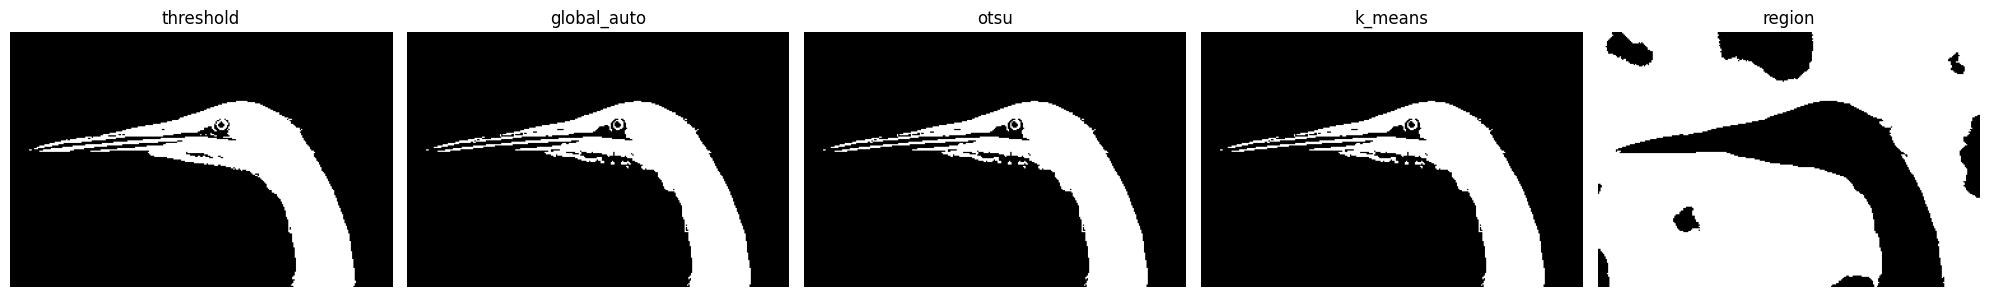

In [ ]:
segmented_images, thresholds= apply_all_segmentations(images_gray[0], seuil=100, epsilon=0.1, k=2, max_iterations=200, seed=(150, 150), sigma_R=20)

# Affichage des images
fig, axs = plt.subplots(1, len(segmented_images), figsize=(20, 5))  # Adapter la taille au besoin
for ax, (method, img) in zip(axs, segmented_images.items()):
    ax.imshow(img, cmap='gray')
    ax.title.set_text(method)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
thresholds

{'manual threshold': 100, 'global_auto': 116.78698364240923, 'otsu': 241}

In [ ]:
metrics= calculate_metrics(segmented_images_gray[0], segmented_images['threshold'], segmented_images['global_auto'], segmented_images['otsu'], segmented_images['k_means'])

In [ ]:
metrics

{'threshold': {'Jaccard': 0.895295625114406},
 'auto_threshold': {'Jaccard': 0.83424858136555},
 'otsu': {'Jaccard': 0.83424858136555},
 'kmeans': {'Jaccard': 0.1821}}

### Images2 :

Text(0.5, 1.0, 'Image en niveaux de gris')

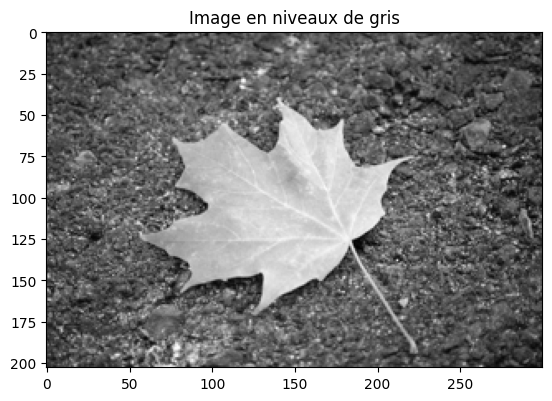

In [ ]:
plt.imshow(images_gray[1], cmap="gray")
plt.title('Image en niveaux de gris')

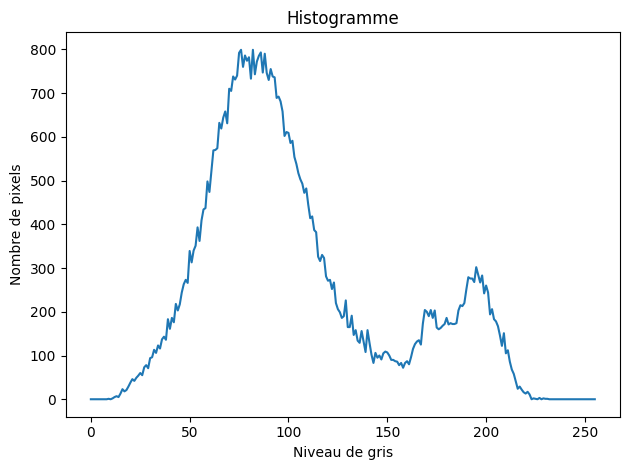

In [ ]:
# Calculer l'histogramme
hist = cv2.calcHist([images_gray[1]], [0], None, [256], [0, 256])
# Afficher l'histogramme
plt.plot(hist)
plt.title('Histogramme')
plt.xlabel('Niveau de gris')
plt.ylabel('Nombre de pixels')

plt.tight_layout()
plt.show()

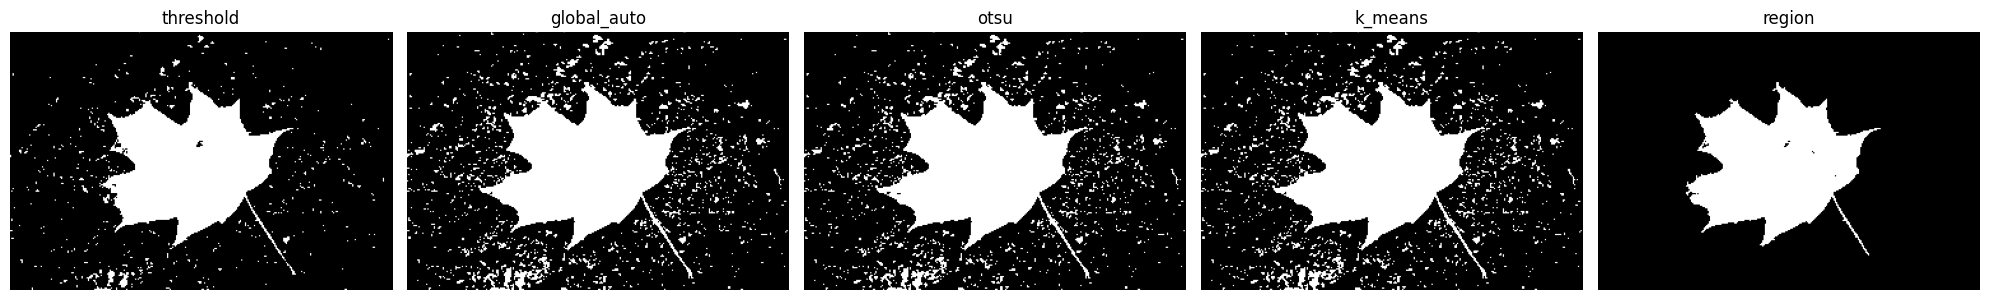

In [ ]:
segmented_images, thresholds = apply_all_segmentations(images_gray[1], seuil=150, epsilon=0.1, k=2, max_iterations=200, seed=(150, 100), sigma_R=35)

# Affichage des images
fig, axs = plt.subplots(1, len(segmented_images), figsize=(20, 5))  # Adapter la taille au besoin
for ax, (method, img) in zip(axs, segmented_images.items()):
    ax.imshow(img, cmap='gray')
    ax.title.set_text(method)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
thresholds

{'manual threshold': 150, 'global_auto': 128.76856329783973, 'otsu': 231}

In [ ]:
metrics= calculate_metrics(segmented_images_gray[1], segmented_images['threshold'], segmented_images['global_auto'], segmented_images['otsu'], segmented_images['k_means'])

In [ ]:
metrics

{'threshold': {'Jaccard': 0.8789455122553341},
 'auto_threshold': {'Jaccard': 0.7472932005197055},
 'otsu': {'Jaccard': 0.759040563338957},
 'kmeans': {'Jaccard': 0.1702463054187192}}

### Image 3:

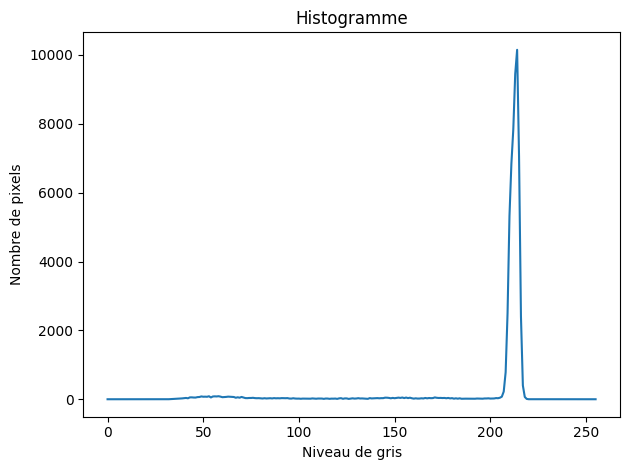

In [ ]:
# Calculer l'histogramme
hist = cv2.calcHist([images_gray[2]], [0], None, [256], [0, 256])
# Afficher l'histogramme
plt.plot(hist)
plt.title('Histogramme')
plt.xlabel('Niveau de gris')
plt.ylabel('Nombre de pixels')

plt.tight_layout()
plt.show()

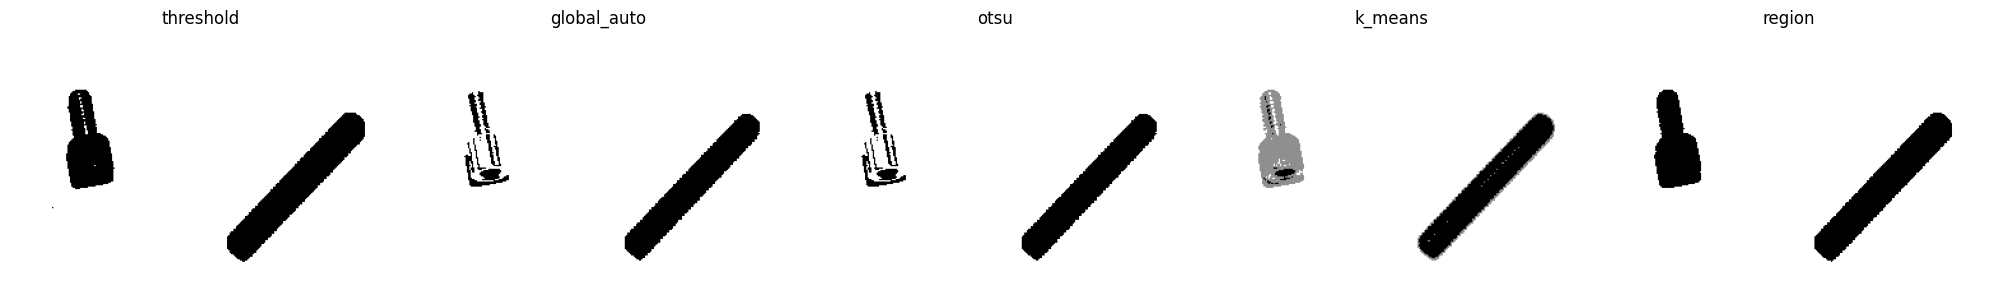

In [ ]:
segmented_images,thresholds = apply_all_segmentations(images_gray[2], seuil=200, epsilon=0.5, k=3, max_iterations=500, seed=(150, 250), sigma_R=20)

# Affichage des images
fig, axs = plt.subplots(1, len(segmented_images), figsize=(20, 5))
for ax, (method, img) in zip(axs, segmented_images.items()):
    ax.imshow(img, cmap='gray')
    ax.title.set_text(method)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
metrics= calculate_metrics(segmented_images_gray[2], segmented_images['threshold'], segmented_images['global_auto'], segmented_images['otsu'], segmented_images['k_means'])

### Image 4

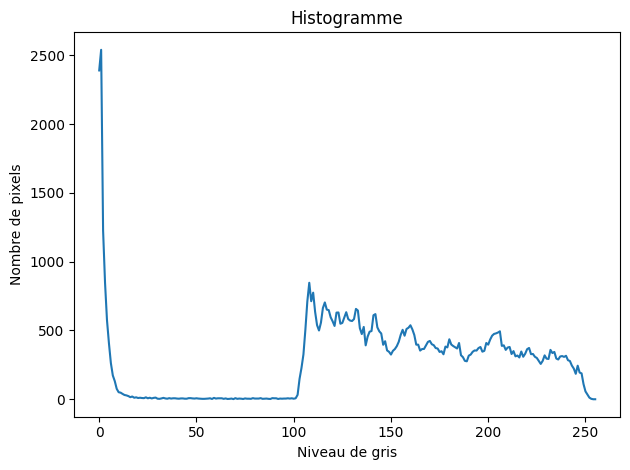

In [ ]:
# Calculer l'histogramme
hist = cv2.calcHist([images_gray[3]], [0], None, [256], [0, 256])
# Afficher l'histogramme
plt.plot(hist)
plt.title('Histogramme')
plt.xlabel('Niveau de gris')
plt.ylabel('Nombre de pixels')

plt.tight_layout()
plt.show()

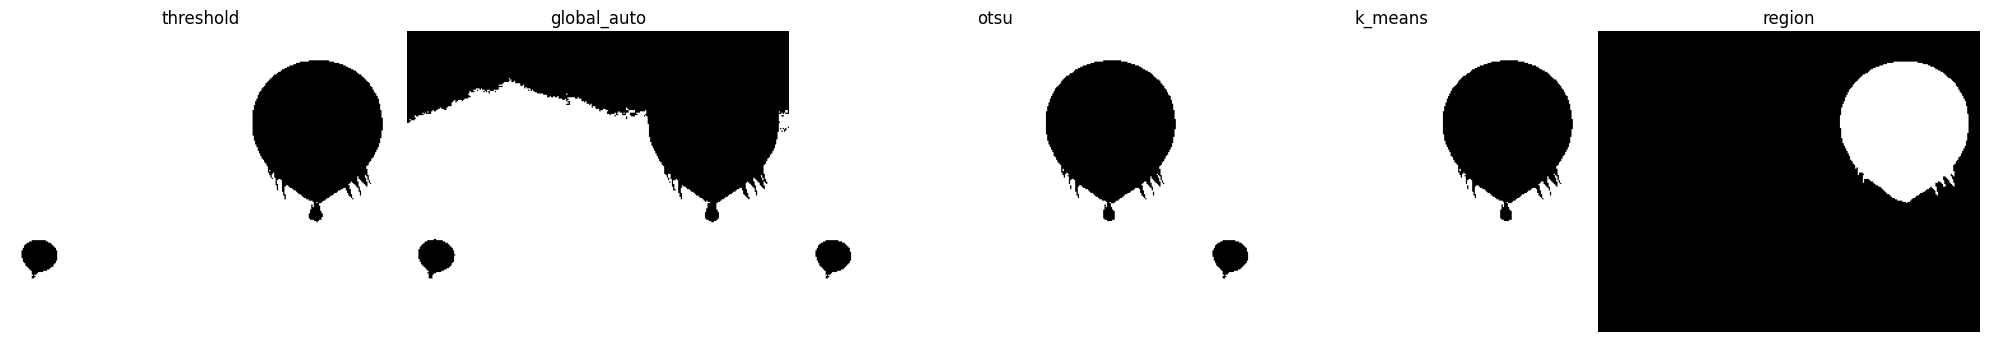

In [ ]:
segmented_images, thresholds = apply_all_segmentations(images_gray[3], seuil=100, epsilon=0.1, k=2, max_iterations=200, seed=(100, 200), sigma_R=30)

# Affichage des images
fig, axs = plt.subplots(1, len(segmented_images), figsize=(20, 5))
for ax, (method, img) in zip(axs, segmented_images.items()):
    ax.imshow(img, cmap='gray')
    ax.title.set_text(method)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
thresholds

{'manual threshold': 100, 'global_auto': 127.91932894772145, 'otsu': 253}

In [ ]:
metrics= calculate_metrics(segmented_images_gray[3], segmented_images['threshold'], segmented_images['global_auto'], segmented_images['otsu'], segmented_images['k_means'])

In [ ]:
metrics

{'threshold': {'Jaccard': 0.9182260115174632},
 'auto_threshold': {'Jaccard': 0.7017501869857891},
 'otsu': {'Jaccard': 0.9193053831311605},
 'kmeans': {'Jaccard': 0.9437570621468927}}

### Image 5

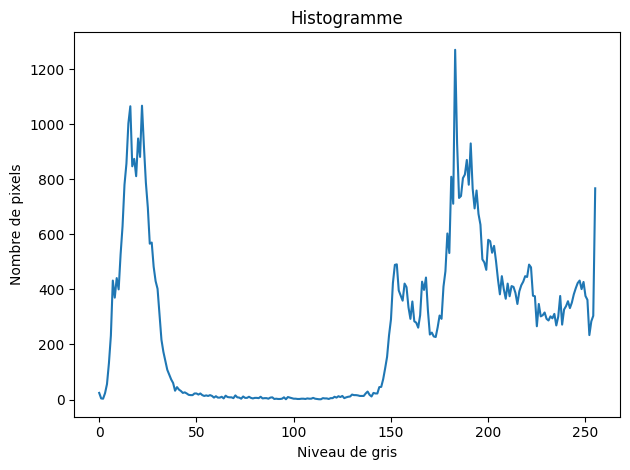

In [ ]:
# Calculer l'histogramme
hist = cv2.calcHist([images_gray[4]], [0], None, [256], [0, 256])
# Afficher l'histogramme
plt.plot(hist)
plt.title('Histogramme')
plt.xlabel('Niveau de gris')
plt.ylabel('Nombre de pixels')

plt.tight_layout()
plt.show()

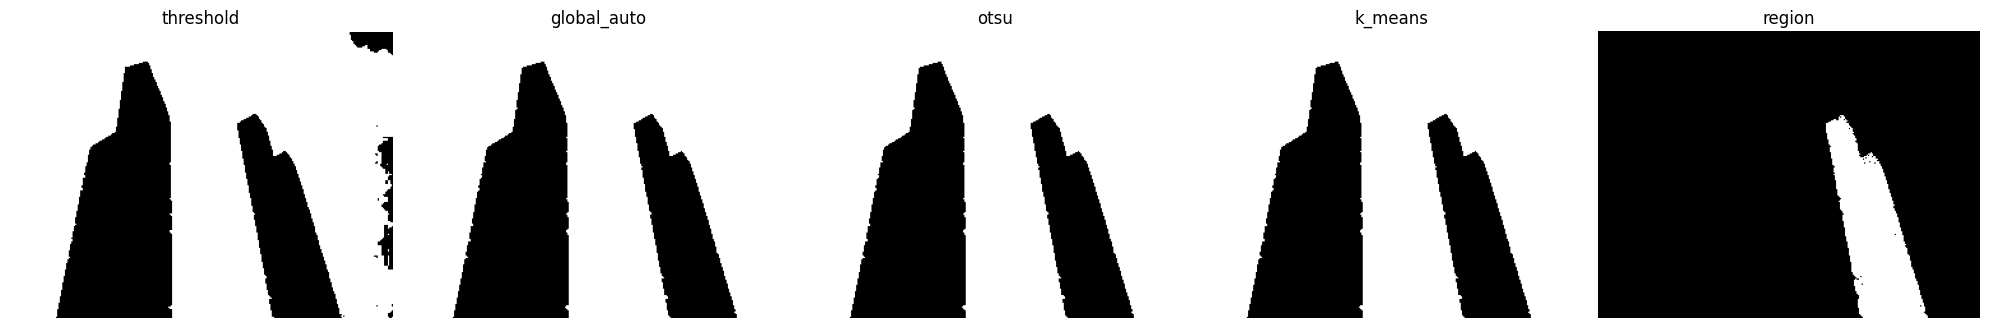

In [ ]:
segmented_images, thresholds = apply_all_segmentations(images_gray[4], seuil=150, epsilon=0.1, k=2, max_iterations=200, seed=(150, 200), sigma_R=20)

# Affichage des images
fig, axs = plt.subplots(1, len(segmented_images), figsize=(20, 5))
for ax, (method, img) in zip(axs, segmented_images.items()):
    ax.imshow(img, cmap='gray')
    ax.title.set_text(method)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
thresholds

{'manual threshold': 150, 'global_auto': 109.97863550818452, 'otsu': 255}

In [ ]:
metrics= calculate_metrics(segmented_images_gray[4], segmented_images['threshold'], segmented_images['global_auto'], segmented_images['otsu'], segmented_images['k_means'])

In [ ]:
metrics

{'threshold': {'Jaccard': 0.9641320238021702},
 'auto_threshold': {'Jaccard': 0.9890392366537797},
 'otsu': {'Jaccard': 0.9890392366537797},
 'kmeans': {'Jaccard': 0.7168444444444444}}

### Image 6

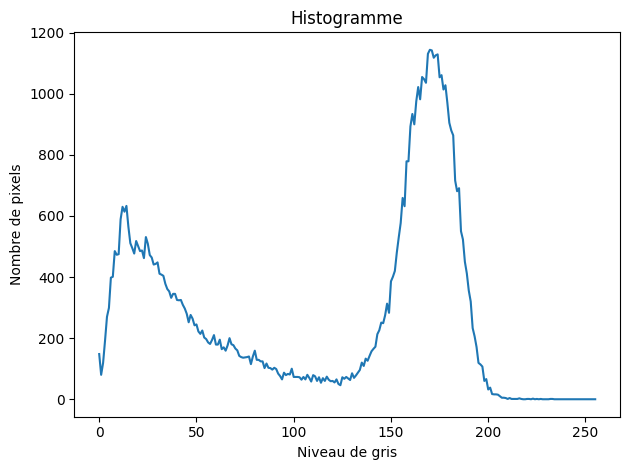

In [ ]:
# Calculer l'histogramme
hist = cv2.calcHist([images_gray[5]], [0], None, [256], [0, 256])
# Afficher l'histogramme
plt.plot(hist)
plt.title('Histogramme')
plt.xlabel('Niveau de gris')
plt.ylabel('Nombre de pixels')

plt.tight_layout()
plt.show()

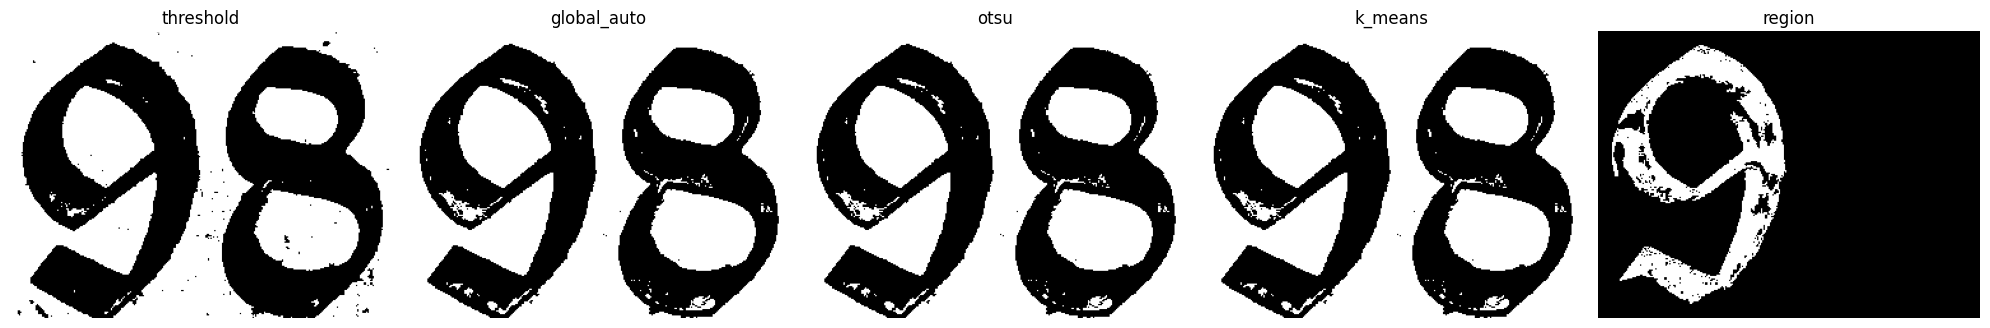

In [ ]:
segmented_images, thresholds = apply_all_segmentations(images_gray[5], seuil=130, epsilon=0.1, k=2, max_iterations=200, seed=(120, 120), sigma_R=20)

# Affichage des images
fig, axs = plt.subplots(1, len(segmented_images), figsize=(20, 5))
for ax, (method, img) in zip(axs, segmented_images.items()):
    ax.imshow(img, cmap='gray')
    ax.title.set_text(method)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
thresholds

{'manual threshold': 130, 'global_auto': 101.46642383424523, 'otsu': 233}

In [ ]:
metrics= calculate_metrics(segmented_images_gray[5], segmented_images['threshold'], segmented_images['global_auto'], segmented_images['otsu'], segmented_images['k_means'])

In [ ]:
metrics

{'threshold': {'Jaccard': 0.9000735654732712},
 'auto_threshold': {'Jaccard': 0.8903992191777561},
 'otsu': {'Jaccard': 0.8903992191777561},
 'kmeans': {'Jaccard': 0.5809185185185185}}

#### Conculsion :




Dans ce TP, nous avons:
1. Importé et Visualisé les Images

  Nous avons chargé diverses images de test et affiché leurs histogrammes pour comprendre leur distribution de niveaux de gris. Cela nous a aidés à identifier les zones séparables et à choisir les seuils de segmentation.
  Segmentation par Seuillage

2. Implémenté l'algorithme de seuillage mannuel et global automatique : Nous avons implémenté une méthode de seuillage automatique qui ajuste dynamiquement le seuil en fonction de l'histogramme de l'image, produisant un résultat similaire au seuillage manuel mais toujours influencé par le bruit.

3.  Nous avons appliqué la méthode d'Otsu pour minimiser la variance intra-classe et obtenir un seuil optimal. Cette méthode s'est avérée plus résistante au bruit comparée aux méthodes de seuillage manuel et automatique.
Segmentation par K-means

4. Nous avons utilisé l'algorithme des K-means pour segmenter l'image "11.png" en différentes classes. Les résultats montrent que : La segmentation est grossière et distingue de manière basique les objets de l'arrière-plan.

5. Segmentation par Croissance de Région

  Nous avons segmenté des régions homogènes autour de points germes avec des critères d'homogénéité définis.


  Segmenté plusieurs régions en utilisant différents points germes (nez, œil droit, joue gauche, joue droite) et observé que la performance dépend fortement de l'initialisation des points germes et des critères d'homogénéité choisis.

6. Application sur un Dataset

Nous avons appliqué les différentes méthodes de segmentation sur un ensemble d'images issues d'un dataset. Chaque image a été segmentée en utilisant les méthodes de seuillage manuel, seuillage global automatique, méthode d'Otsu, K-means, et croissance de région.
Nous avons évalué les résultats de segmentation en utilisant des métriques de performances basées sur les notions de TP, FP, FN, TN, et calculé les coefficients de Dice et les indices de Jaccard pour comparer les performances des différentes méthodes.


#Conclusion
Les résultats de segmentation dépendent fortement des caractéristiques spécifiques de chaque image. Les facteurs clés incluent :

* Contenu de l'Image:

  Les objets présents, leur forme, et leur contraste par rapport à l'arrière-plan affectent directement la segmentation. Des images avec des objets bien définis et contrastés facilitent une segmentation précise.
* Éclairage

  Une variation d'éclairage peut provoquer des erreurs de segmentation, nécessitant des méthodes adaptatives pour compenser ces variations.
* Texture

  La texture de l'image joue un rôle crucial dans la segmentation par méthodes de classification et par croissance de région. Des images avec des textures homogènes sont plus faciles à segmenter de manière cohérente.
* Bruit

  La présence de bruit peut dégrader la qualité de la segmentation, rendant difficile la distinction entre les régions d'intérêt et le bruit. La méthode d'Otsu offre une meilleure résistance au bruit, mais elle n'est pas infaillible.



En résumé, ce TP a permis d'explorer et de comparer différentes méthodes de segmentation, soulignant l'importance de l'adaptation des techniques en fonction des propriétés spécifiques des images analysées.